Pipeline to process MERSCOPE experiments as they come in. The pipeline has the following basic steps:  
1. Assessment of total counts and corrlation to bulkseq
2. Re-segmentation using Cellpose
3. QC of cells and filtering out low quality ones
4. Creation of AnnData object for primary analysis
5. Mapping with Tangram
6. First stage analysis of mapping  

This notebook should be able to run by providing the MERSCOPE barcode and the gene panel to use. However, for coverslips which had 2 sections additional processing steps to separate the sections may be necessary.

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import anndata

from sawg.celltype_mapping import ScrattchMapping
from sawg.spot_table import SpotTable

In [151]:
barcode = '1291813638'
# training_genes = 'mFISHtools'
# mapping_level = 'cluster'
# mapping_threshold = 0.1

In [152]:
# set paths for data

# base network data path
data_path = '//allen/programs/celltypes'

# # vizgen gene panel path
# vzg_panel_path = data_path + '/workgroups/rnaseqanalysis/NHP_spatial/Vizgen panels'

# save path
out_path = data_path + '/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/' + barcode
if not os.path.exists(out_path):
    os.mkdir(out_path)

# raw spatial data
merscope_production_path = data_path + '/production/mfish/mfishmerscopemacaqueatlas/'
merscope_data_path = merscope_production_path + barcode
if os.path.isdir(merscope_data_path) is False:
    print(f'{merscope_data_path} is not a directory, trying another search...')
    # barcode might be part of another dataset
    outer_path = [dirpath for dirpath, _, _ in os.walk(merscope_production_path) if barcode in dirpath][0]
    merscope_data_path = outer_path + '/' + barcode
    if os.path.isdir(merscope_data_path) is False:
        print(f'{merscope_data_path} is not a directory')

sp_csv_file = [os.path.join(dirpath,filename) for dirpath, _, filenames in os.walk(merscope_data_path) for filename in filenames if filename.startswith('detected_transcripts')][0]
sp_cache_file = out_path + '/detected_transcripts.npz'

# # spatial metadata
# coverslip_meta_file = data_path + '/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/MerscopeCoverslipProcessing.csv'
# request_meta_file = data_path + '/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/MerscopeImagingRequest.csv'

# spatial AnnData file
sp_anndata_file = out_path + '/sp_anndata.h5ad'

# taxonomy path
taxonomy = data_path + '/workgroups/rnaseqanalysis/shiny/10x_seq/NHP_BG_AIT_115'

# bulkseq file
bulk_file  = data_path + '/workgroups/rnaseqanalysis/NHP_spatial/bulkseq/macaque/QM22.26.030.CAB_abundance.tab'

# path for storing  mapping
mapping_path = out_path + '/mapping'

hpc_path = data_path  + '/workgroups/rnaseqanalysis/NHP_spatial/hpc-jobs/'

In [ ]:
# TODO:
# - Do some checks on whether this barcode has been processed and if you want to re-process
# - Add some progress output info to aid in this

1. Load detected transcripts, calculate total counts, and correlate to bulk-seq  
  TODO: 
- For now just using a single specimen reference for bulk-seq, figure out if we need to pool across multiple specimens

In [153]:
data_table = SpotTable.load_merscope(sp_csv_file, sp_cache_file)

bulk_data = pd.read_csv(bulk_file, sep='\t')
bulk_data.set_index('Gene Name', inplace=True)

Loading from npz..


In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

data_table[::300].scatter_plot(ax=ax)
plt.axis('off')

In [154]:
def spatial_corr_to_bulk(sp_data:SpotTable, bulk_data:pd.DataFrame, save_path):
    sp_genes, sp_total_counts = np.unique(sp_data.gene_names, return_counts=True)
    
    total_counts = pd.DataFrame({'gene': sp_genes, 'spatial total counts': sp_total_counts})
    total_counts.set_index('gene', inplace=True)
    total_counts = total_counts.merge(bulk_data['FPKM'], left_index=True, right_index=True, how='inner')
    
#     for col in total_counts.columns:
#         total_counts[col + ' log'] = np.log(total_counts[col])
            
    total_counts_corr = total_counts.corr()['spatial total counts']['FPKM']
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    sp_data[::1000].scatter_plot(ax[0])
    sns.scatterplot(data=total_counts, x='spatial total counts', y='FPKM', alpha=0.5, lw=0, ax=ax[1])
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title(f'Pearson corr: {total_counts_corr:0.3f}')
    plt.tight_layout()
    
    fig.savefig(save_path + '/correlation_to_bulk.pdf')
    

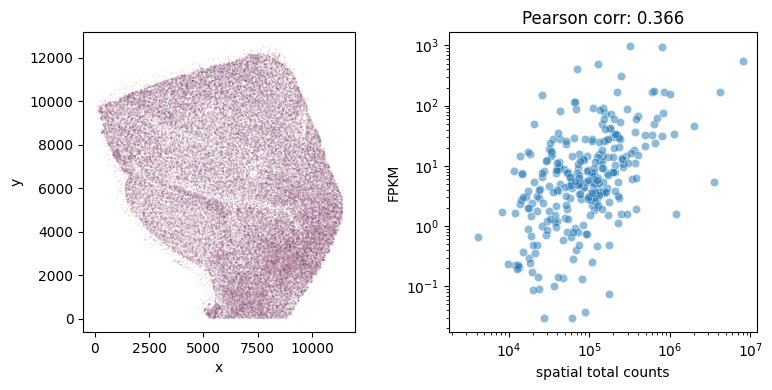

In [155]:
spatial_corr_to_bulk(sp_data=data_table, bulk_data=bulk_data, save_path=out_path)

2. Resegment cells by gene using Cellpose 
- Currently Vizgen has provided a docker image to run re-segmentation that runs on the HPC  
- For the time being, do this as a step outside of this notebook  
TODO:  
- Luke working on better segmentation with Cellpose and adding Baysor
- Incorporate this step better into pipeline

3. QC cells  
Current parameters for qc'ing include:  
- Volume
- Number of genes
- Number of spots/transcripts  
Other parameters and bounds on these can be altered and provided to `qc_cells`

In [111]:
def load_cellpose_segmentation(root_path):
    # root_path: where to look for the resegmented data
    # path to resegmented data
    cellpose_path = [dirpath for dirpath, _, _ in os.walk(root_path) if dirpath.endswith('cellpose_cyto2_nuclei')]
    if len(cellpose_path) != 1:
        print('Check that resegementation has been completed')
    else:
        cellpose_path = cellpose_path[0]

    cbg = pd.read_csv(cellpose_path + '/cellpose-cell-by-gene.csv')
    cbg.set_index('cell', inplace=True)
    cbg.index = cbg.index.astype('str')

    cbg_meta = pd.read_csv(cellpose_path + '/cellpose_metadata.csv')
    cbg_meta.rename(columns={'id': 'cell', 'center_x': 'x', 'center_y': 'y'}, inplace=True)
    cbg_meta.set_index('cell', inplace=True)
    cbg_meta.index = cbg_meta.index.astype('str')
    
    # make sure that the dataframes have the same cells and order
    cbg_meta = cbg_meta.reindex(cbg.index)
    assert cbg.index.equals(cbg_meta.index), 'Cell by gene table and cell by gene metadata indeces do not match'
    
    return cbg, cbg_meta
    
def qc_cells(cbg: pd.DataFrame, cbg_meta: pd.DataFrame, save_path,
                    qc_params: dict={'volume': [100, 3500], 'n_genes': [20, 420], 'n_transcripts': [100, 3500]}):
    
    gene_cols = [col for col in cbg.columns if not col.startswith('Blank')]
    cbg_meta['n_transcripts'] = cbg[gene_cols].sum(axis=1)
    cbg_meta['n_genes'] = cbg[cbg[gene_cols] != 0].count(axis=1)
    
    fig1, ax = plt.subplots(1, 3, figsize=(12,4))
    plt.tight_layout()

    qc_pass = None
    for i, (param, bounds) in enumerate(qc_params.items()):
        sns.violinplot(data=cbg_meta, y=param, cut=0, ax=ax[i])
        ax[i].axhline(bounds[0], ls='--', c='grey')
        ax[i].axhline(bounds[1], ls='--', c='grey')
        ax[i].set_ylim(-10 , bounds[1] + bounds[1]*0.5)
        filt = cbg_meta[param].between(bounds[0], bounds[1])
        if qc_pass is None:
            qc_pass = filt
        else:
            qc_pass = qc_pass & filt
    
    plt.tight_layout()
    fig1.savefig(save_path + '/cell_qc_parameters.pdf')

    
    cbg_meta['cell_qc'] = None
    cbg_meta['cell_qc'].mask(qc_pass, other='pass', inplace=True)
    cbg_meta['cell_qc'].mask(~qc_pass, other='fail', inplace=True)
    
    fig2, ax = plt.subplots(1, 2, figsize=(15, 8))
    sns.scatterplot(data=cbg_meta, x='x', y='y', alpha=0.4, s=2, color='grey', ax=ax[0])
    ax[0].set_title(f'All: {len(cbg_meta)} cells')
    sns.scatterplot(data=cbg_meta[cbg_meta['cell_qc']=='pass'], x='x', y='y', alpha=0.4, s=2, color='grey', ax=ax[1])
    ax[1].set_title(f"QC: {len(cbg_meta[cbg_meta['cell_qc']=='pass'])} Pass")
    
    fig2.savefig(save_path + '/cell_qc_filter.pdf')
    
    return  cbg_meta, qc_params


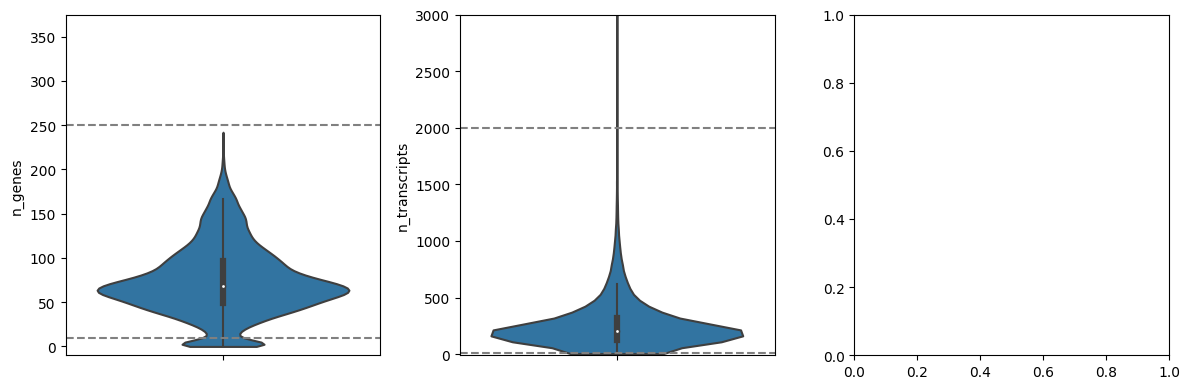

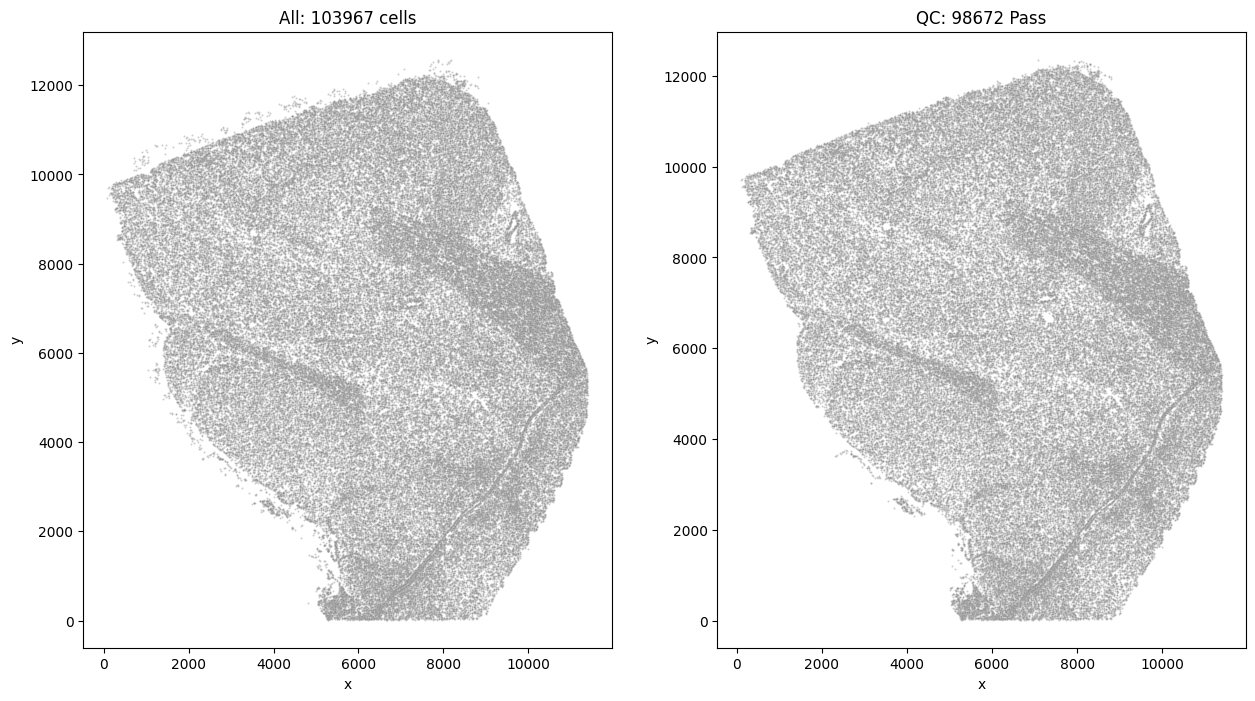

In [156]:
# cbg, cbg_meta = load_cellpose_segmentation(out_path)
# segmentation = 'cellpose'

cbg = anndata.read_h5ad(out_path + '/segmentation/2D/cell_by_gene.h5ad')

qc_params = {'n_genes': [10, 250], 'n_transcripts': [10, 2000]}
cbg_meta, qc_params = qc_cells(cbg=cbg.to_df(), cbg_meta=cbg.obs, save_path=out_path, qc_params=qc_params)

4. Generate AnnData object for spatial data  
- X = qc-pass cell x gene 
- obs = cell metadata dataframe
- obs_names = cell names (cbg index)
- var = gene metadata dataframe (gene or blank)
- var_names = gene names (cbg columns)
- uns = experiment metadata  
TODO:
- Currently metadata is being pulled from csv file, switch to LIMS when that is integrated

In [113]:
def get_exp_metadata(coverslip_meta_file: str, request_meta_file: str, barcode: str, meta_cols: list=None):
    coverslip_meta = pd.read_csv(coverslip_meta_file)
    request_meta = pd.read_csv(request_meta_file)
    spatial_exp_meta = coverslip_meta.merge(request_meta, left_on='MerscopeImagingRequestID', right_on='ID', suffixes=('_coverslip', '_request'))
    barcode_meta = spatial_exp_meta[spatial_exp_meta['Barcode']==barcode]
    cols=[
            'Specimen', 
            'ROI',
            'Species',
            'GenePanel',
        ]
    
    if meta_cols is not None:
        cols.extend(meta_cols)
        
    exp_meta = barcode_meta[cols].to_dict(orient='records')
    if len(exp_meta) != 1:
        print('Could not find experiment metadata')
        return None
    
    return exp_meta[0]

def make_spatial_anndata(cbg: pd.DataFrame, cbg_meta: pd.DataFrame, exp_meta: dict, cell_qc: str='pass'):
    from collections import OrderedDict
    
    cbg_filtered = cbg[cbg_meta['cell_qc']==cell_qc]
    cbg_meta_filtered = cbg_meta[cbg_meta['cell_qc']==cell_qc]

    gene_meta = pd.DataFrame(index=cbg_filtered.columns)
    gene_meta['probe_type'] = None
    gene_meta['probe_type'] = gene_meta.apply(lambda x: 'blank' if x.name.startswith('Blank') else 'gene', axis=1)

    ad_sp = anndata.AnnData(
        X = cbg_filtered,
        obs = cbg_meta_filtered,
        var = gene_meta,
        uns = OrderedDict(exp_meta),
    )
    print(ad_sp.uns)

    ad_sp.obs_names = cbg_filtered.index.astype('str')
    ad_sp.var_names = cbg_filtered.columns
    ad_sp.layers['logcounts'] = np.log1p(ad_sp.X)
    
    return ad_sp

In [157]:
# exp_meta = get_exp_metadata(coverslip_meta_file, request_meta_file, '1223198166, 1223198444')
exp_meta = {
    'Specimen': 'QM23.50.001.CX.44.04.07', 
    'ROI': 'Basal Ganglia',
    'Species': 'Macaque',
    'GenePanel': 'BM1205',
}
exp_meta.update({
    'segmentation': '2D: cellpose_20230919_3species_merscope',
    'cell_qc_params': qc_params,
    'method': 'MERSCOPE',
    'barcode': barcode
})

ad_sp = make_spatial_anndata(cbg.to_df(), cbg_meta, exp_meta)
ad_sp.write_h5ad(sp_anndata_file)

OrderedDict([('Specimen', 'QM23.50.001.CX.44.04.07'), ('ROI', 'Basal Ganglia'), ('Species', 'Macaque'), ('GenePanel', 'BM1205'), ('segmentation', '2D: cellpose_20230919_3species_merscope'), ('cell_qc_params', {'n_genes': [10, 250], 'n_transcripts': [10, 2000]}), ('method', 'MERSCOPE'), ('barcode', '1291813638')])


5. Map 
- Create CellTypeMapping object
- Set training genes
- Map at the cluster level and merge back up to subclass and class

ScrattchMapping

In [158]:
scrattch_map = ScrattchMapping(
    sp_data = ad_sp,
    taxonomy_path = taxonomy,
)

In [159]:
ad_map_args = {'save_path': mapping_path, 
              'ad_sp_layer': 'logcounts',
              }
hpc_args = {
    'job_path': hpc_path + 'scripts/',
    'output': hpc_path + '/%j.out',
    'error': hpc_path + '/%j.err',
}
docker = 'singularity exec --cleanenv docker://njjai/scrattch_mapping:0.51'

job = scrattch_map.run_on_hpc(ad_map_args, hpc_args, docker=docker)

Setting run directory to //allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/MERSCOPE/macaque/1291813638/mapping
Mapping UID: 1699474526.050
building HPC job
<JobState RUNNING> 11914380


In [161]:
job.state()

<JobState RUNNING>

In [162]:
scrattch_map.load_scrattch_mapping_results()

loading results...
deleting scrattch-mapping temp file...


<AxesSubplot:xlabel='score.Corr', ylabel='Count'>

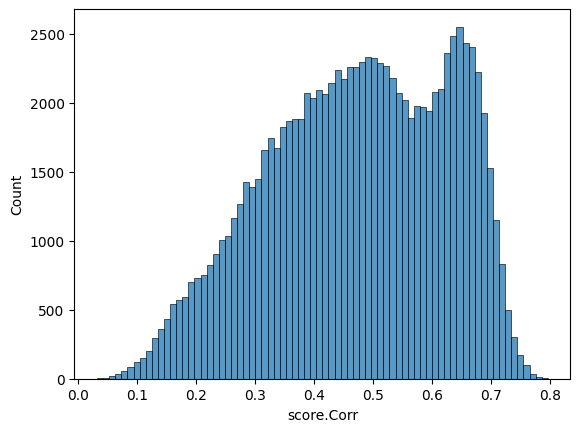

In [163]:
sns.histplot(data=scrattch_map.ad_map.obs, x='score.Corr')

In [122]:
def qc_mapping(ad_map, qc_params: dict):
    # QC mapping results using thresholds for various performance metrics in self.ad_map.obs

    qc_mask = None
    ad_map.obs['mapping_qc'] = 'pass'
    for param, thresh in qc_params.items():
        if qc_mask is None:
            qc_mask = (ad_map.obs[param] < thresh)
        else:
            qc_mask = qc_mask & (ad_map.obs[param] < thresh)

    ad_map.obs.loc[qc_mask, 'mapping_qc'] = 'fail'
    ad_map.uns['qc_params'] = qc_params
    
def plot_best_mapping(ad_map, level: str, groups=None, args: dict={}, qc_pass=True):
        """Plot the best mapping at particular heirarchy level. Optionally provide a dictionary with keys specifying group
        names and keys a list of labels to plot separately for easier visualization.  
        """
        scatter = {'s': 10, 'alpha': 0.7, 'linewidth': 0}
        scatter.update(args)

        if qc_pass is True and 'mapping_qc' in ad_map.obs.columns:
            print('showing qc_ed mapping')
            data = ad_map.obs[ad_map.obs['mapping_qc']=='pass']
        else:
            data = ad_map.obs

        if groups is not None:
            fig, ax = plt.subplots(len(groups), 1, figsize=(8, len(groups)*6))
            for i, (group_name, group) in enumerate(groups.items()):
                sns.scatterplot(data=ad_map.obs, x='x', y='y', ax=ax[i], color='grey', s=3, alpha=0.1, lw=0)
                subdata = data[data[level].isin(group)]
                sns.scatterplot(data=subdata, x='x', y='y', hue=level, ax=ax[i], hue_order=group, **scatter)
                ax[i].set_title(group_name)
                ax[i].legend(bbox_to_anchor=(1,1))

            fig.set_tight_layout(True)


        else:
            fig, ax = plt.subplots(figsize=(8, 8))
            sns.scatterplot(data=data, x='x', y='y', hue=level,ax=ax, **scatter)
            ax.legend(bbox_to_anchor=(1,1))

        return fig

In [164]:
qc_mapping(scrattch_map.ad_map, qc_params={'score.Corr': 0.3})

In [146]:
scrattch_map.ad_map.obs.head()

x           y  n_transcripts  n_genes cell_qc  score.Corr  \
2  7648.018555  204.295685           1082      161    pass    0.344134   
3  7651.453125  229.759308            442      114    pass    0.474107   
4  7640.709961  236.893799            426       96    pass    0.518172   
5  7651.307129  258.512756            515      115    pass    0.526439   
6  7662.748535  265.328369            221       82    pass    0.399159   

  level1.class_Corr level2.neighborhood_Corr level3.subclass_Corr  \
2               MSN                   D2-MSN           D2-ShellOT   
3                NN               Oligos_Pre           Oligos_Pre   
4                NN              Endothelial          Endothelial   
5                NN                   Oligos               Oligos   
6                NN               Astrocytes           Astrocytes   

  cluster_Corr mapping_qc  
2       82_MSN       fail  
3         9_NN       pass  
4        12_NN       pass  
5        20_NN       pass  
6        14_NN       fail

In [148]:
subclass = {}
neighborhood = {}
for cls in scrattch_map.ad_map.obs['level1.class_Corr'].unique():
    neighborhoods = scrattch_map.ad_map.obs[scrattch_map.ad_map.obs['level1.class_Corr']==cls]['level2.neighborhood_Corr'].unique()
    neighborhood[cls] = neighborhoods
    subclasses = scrattch_map.ad_map.obs[scrattch_map.ad_map.obs['level1.class_Corr']==cls]['level3.subclass_Corr'].unique()
    subclass[cls] = subclasses

showing qc_ed mapping


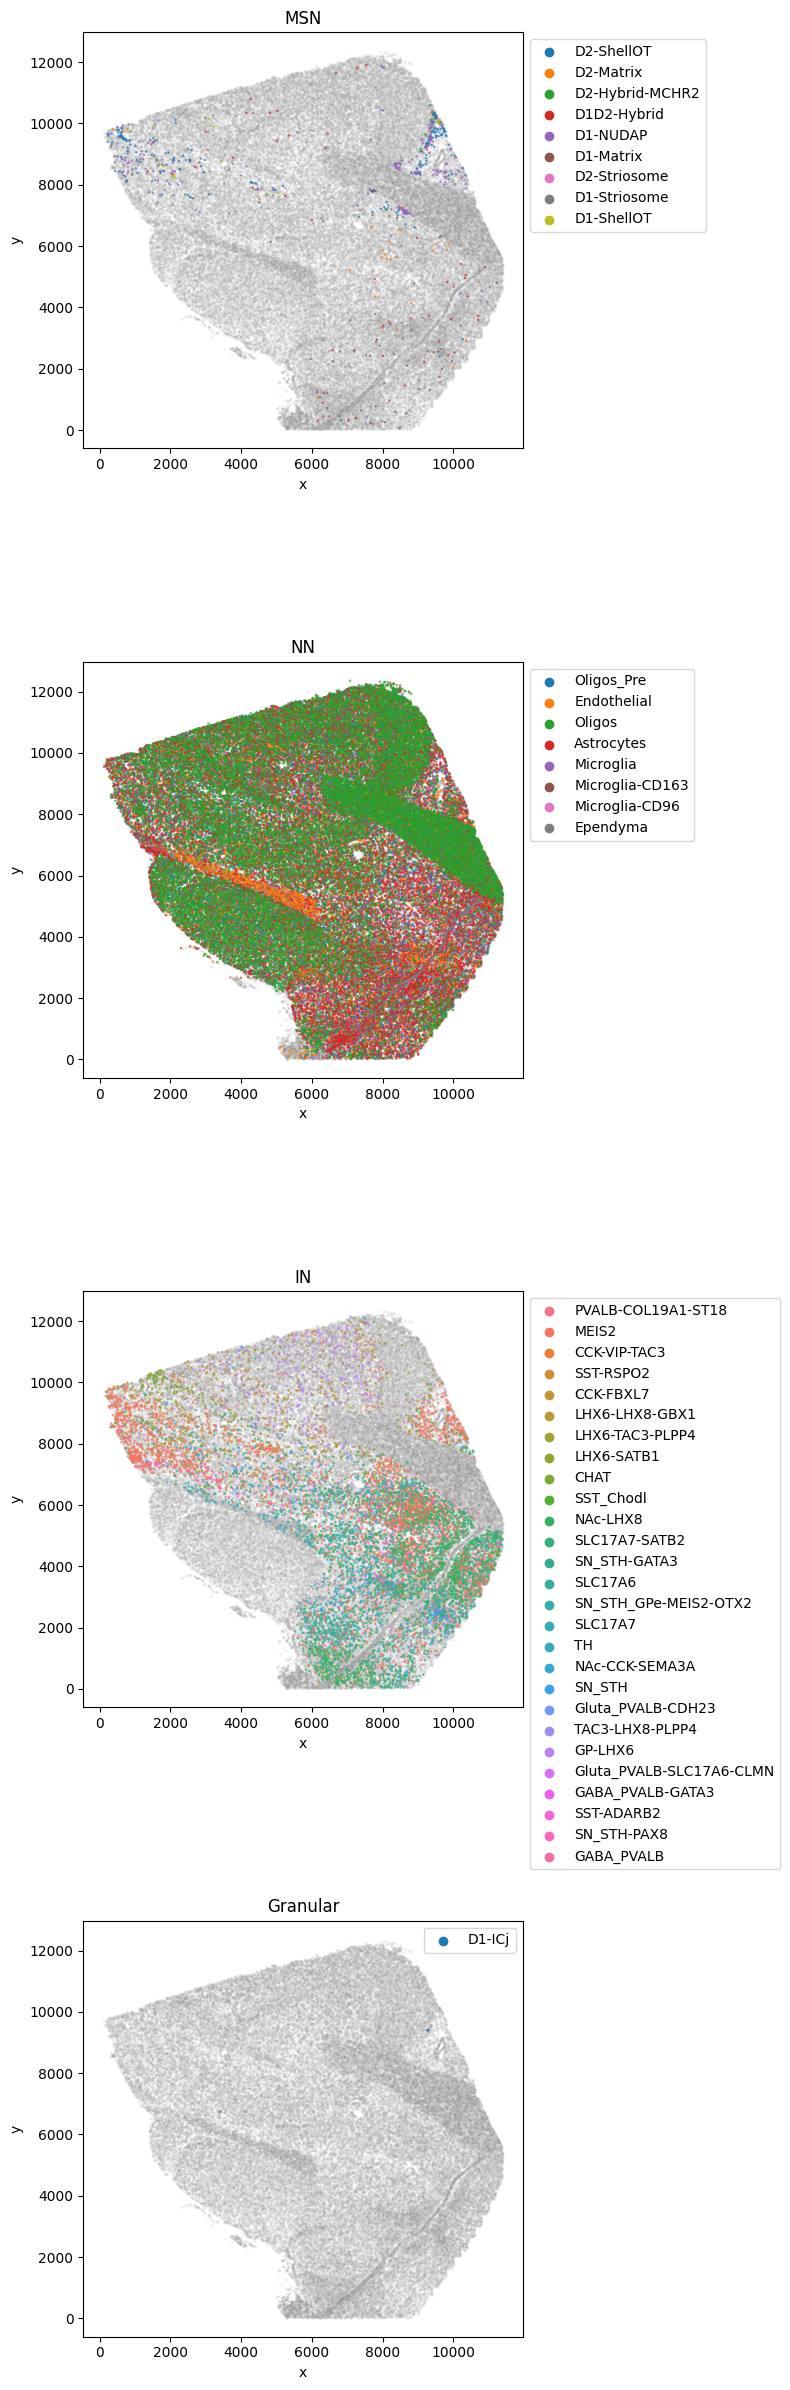

In [165]:
scatter_args = {
    's':3,
}
fig =plot_best_mapping(scrattch_map.ad_map, level='level3.subclass_Corr', groups=subclass, args=scatter_args)

TangramMapping

In [13]:
def get_training_genes(gene_panel_name=None, training_genes=None):
    if type(training_genes) == list:
        return training_genes
    if gene_panel_name is not None:
        gene_panel = pd.read_csv(vzg_panel_path + '/' + gene_panel_name + '.csv', header=None)
        if gene_panel.shape[1] > 1:
            # assume that there are multiple gene sets within panel and first row are headers
            gene_panel.columns = gene_panel.iloc[0]
            gene_panel.drop(gene_panel.index[0], inplace=True)
            gene_panel.reset_index(inplace=True)
            if type(training_genes) == str:
                try:
                    tg_list = gene_panel[training_genes].dropna().tolist()
                except KeyError:
                    print(f'{training_genes} is not a column in {gene_panel_name}, returning all genes')
                    all_genes = gene_panel.values.tolist()
                    tg_list = [g for sublist in all_genes for g in sublist if type(g)==str]
        else:
            all_genes = gene_panel.values.tolist()
            tg_list = [g for sublist in all_genes for g in sublist if type(g)==str]
        return tg_list

In [14]:
tg_map = TangramMapping(
    sc_data=sc_anndata_file, 
    sp_data=sp_anndata_file, 
    meta={'MERSCOPE barcode': barcode,}
)

gene_panel_name = tg_map.ad_sp.uns['GenePanel']

training_genes_list = get_training_genes(gene_panel_name, training_genes)

In [15]:
tg_map.set_training_genes(training_genes_list, meta={'training_genes': training_genes})

starting with 150 training genes..


INFO:root:134 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:490 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [16]:
tg_map.mapping(cluster_label=mapping_level)
tg_map.save_mapping(save_path=out_path)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 134 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.526, KL reg: 0.278
Score: 0.843, KL reg: 0.001
Score: 0.849, KL reg: 0.001
Score: 0.851, KL reg: 0.001
Score: 0.851, KL reg: 0.001
Score: 0.852, KL reg: 0.001
Score: 0.852, KL reg: 0.001
Score: 0.852, KL reg: 0.001
Score: 0.852, KL reg: 0.001
Score: 0.852, KL reg: 0.001


INFO:root:Saving results..


In [4]:
# reload mapping if present
tg_map = TangramMapping.load_from_timestamp(directory=out_path, timestamp='1674519360.130')
print(tg_map.meta)

{'MERSCOPE barcode': '1223198444', 'training_genes': 'mFISHtools', 'mode': 'clusters', 'cluster_label': 'cluster'}


6. Do some basic analysis and make some plots
- Mapping probability distributions
- Mapping scatter plots, cluster level grouped by neighborhood

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


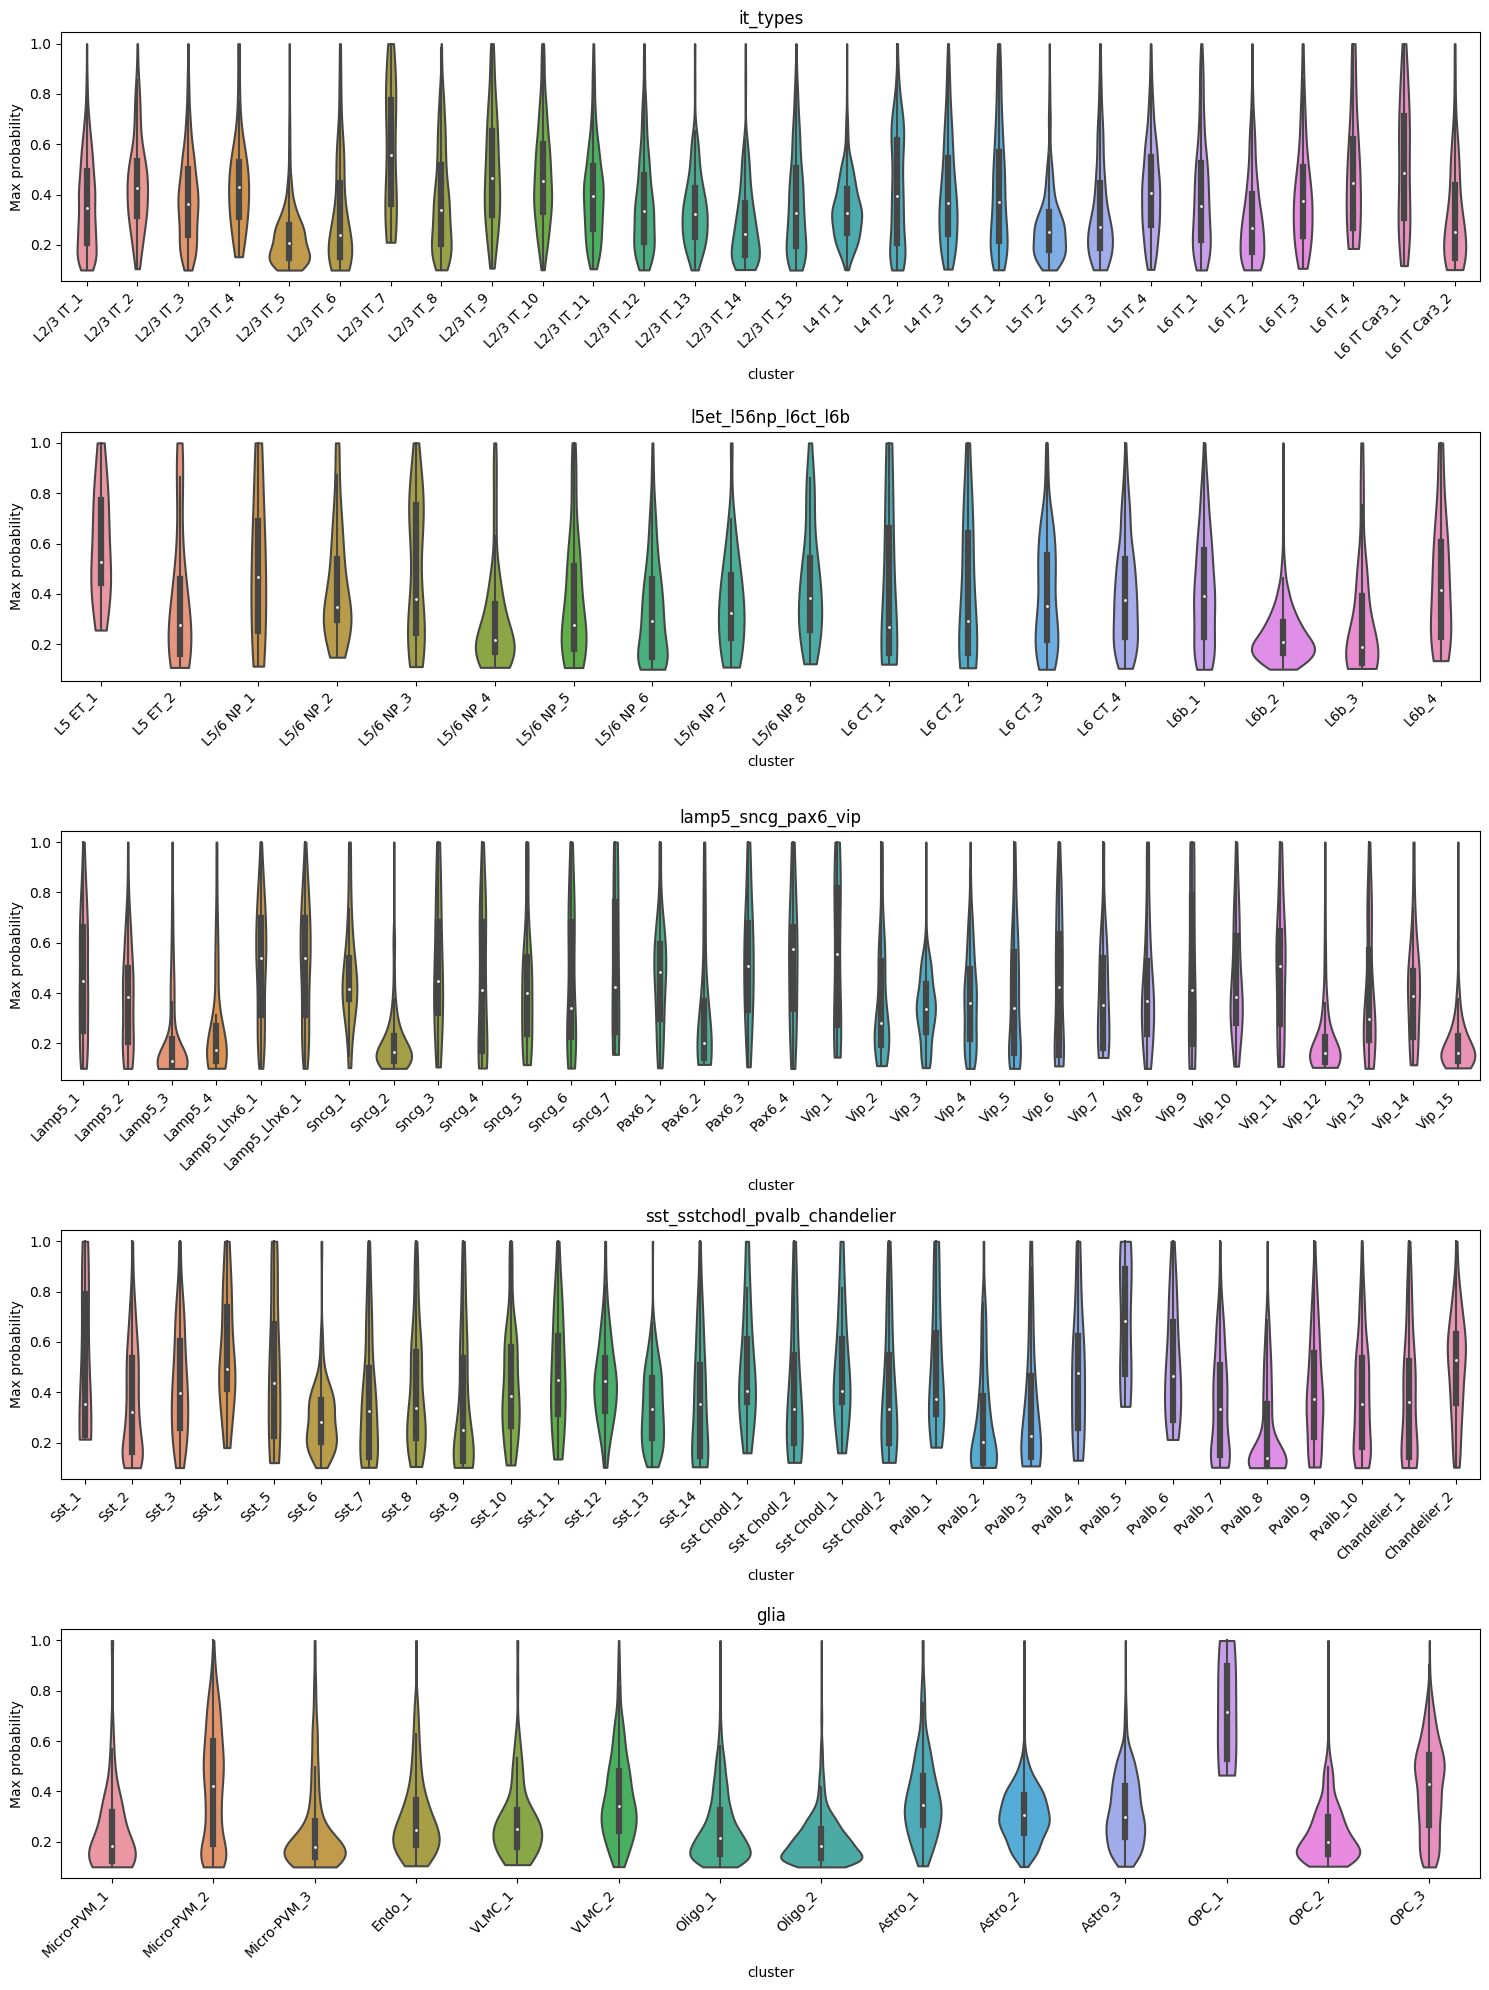

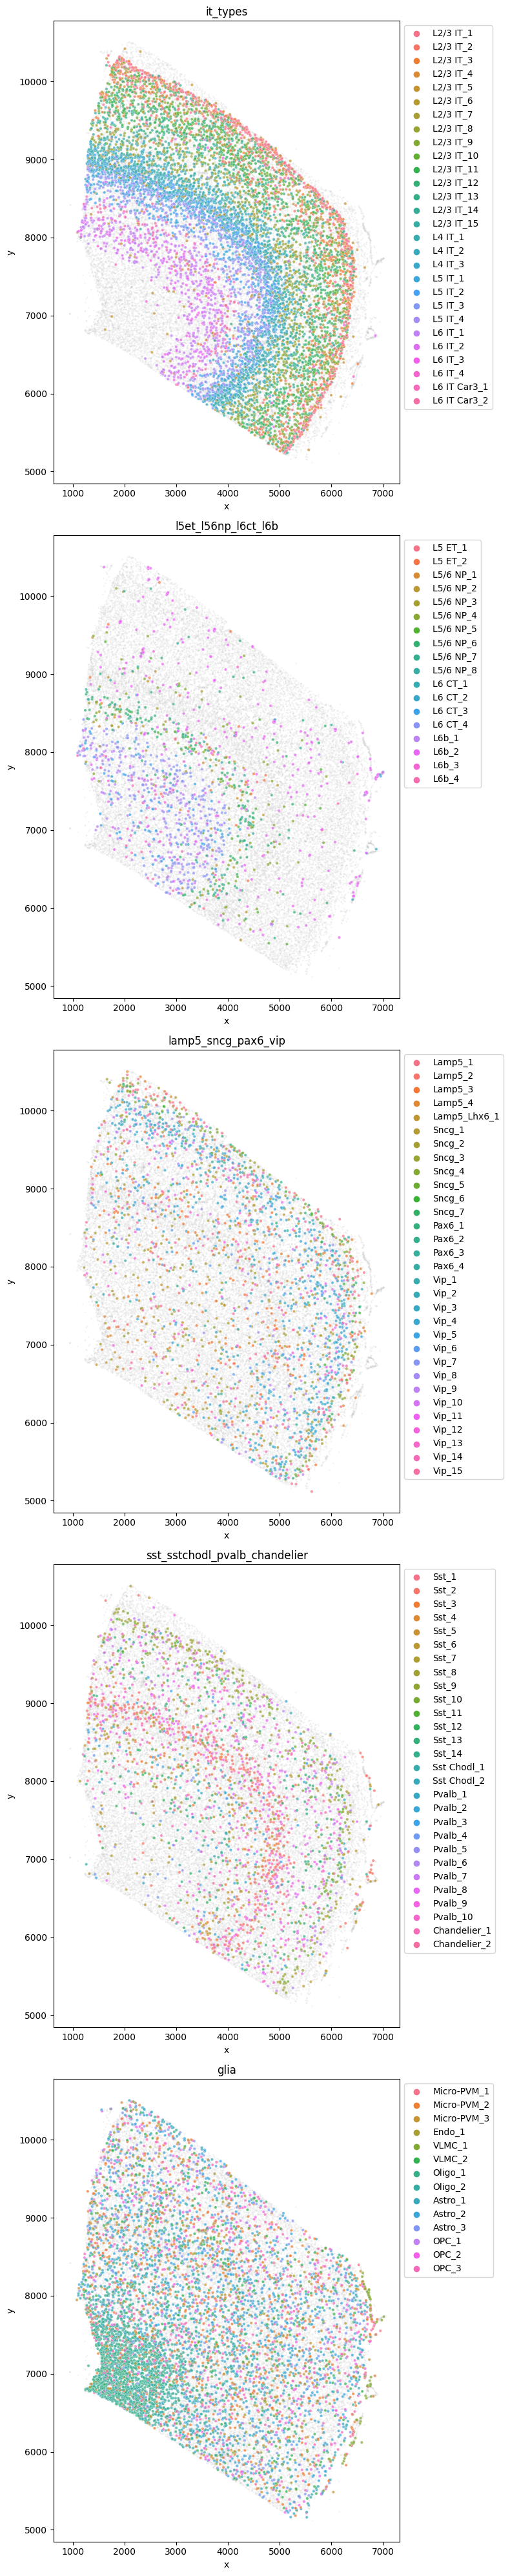

In [5]:
# discretize cell type mapping

tg_map.get_discrete_cell_mapping(threshold=mapping_threshold)

groups = {}
for cls in ['exc', 'inh', 'glia']:
    for neighborhood in tg_map.ordered_labels[cls]:
        groups[neighborhood] = [cl for clusters in list(tg_map.ordered_labels[cls][neighborhood].values()) for cl in clusters]

fig1 = tg_map.plot_discrete_mapping_probability(groups=groups)
fig2 = tg_map.plot_discrete_mapping(level=mapping_level, groups=groups)

fig1.savefig(out_path + '/celltype_mapping_score.pdf')
fig2.savefig(out_path + '/celltype_mapping_scatter.png', dpi=600)